#### Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models.
LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.


#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

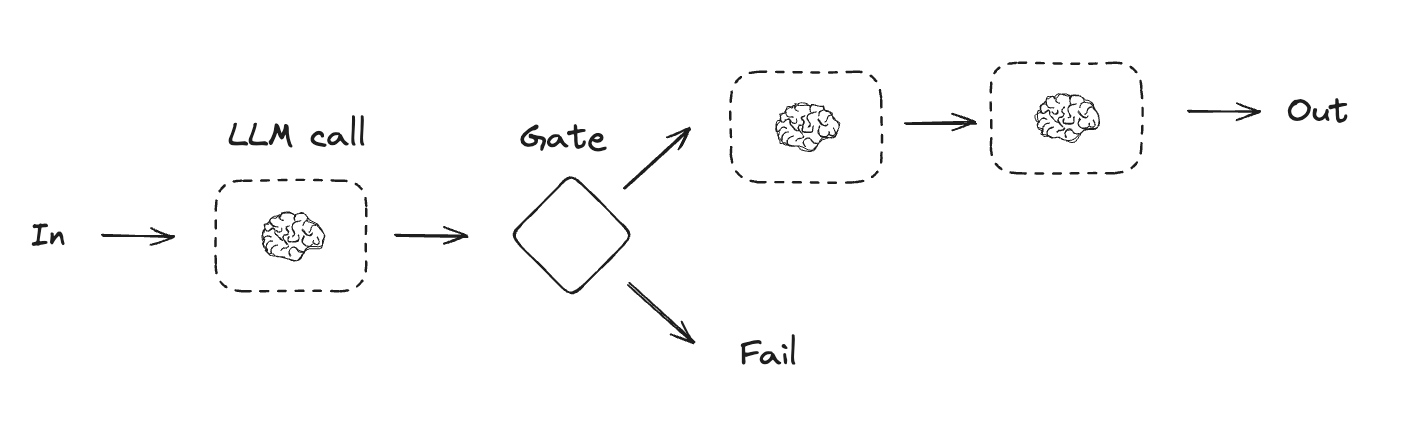



In [16]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I should respond politely. Let me think of a friendly greeting. Maybe "Hello! How can I assist you today?" That sounds good. It\'s open-ended and invites them to ask for help. I\'ll go with that.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 11, 'total_tokens': 77, 'completion_time': 0.153767537, 'prompt_time': 0.004651716, 'queue_time': 3.955703361, 'total_time': 0.158419253}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run--85945a27-a8f9-4411-9c68-ae78baa99847-0', usage_metadata={'input_tokens': 11, 'output_tokens': 66, 'total_tokens': 77})

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display

## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

## Nodes
def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state['topic']}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}



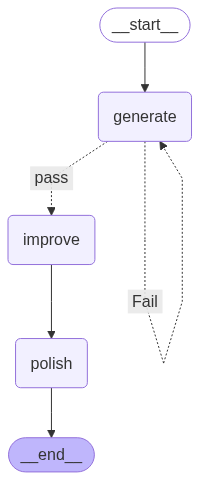

In [20]:
#Build the graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))


In [13]:
## Run the graph

state={"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '\n<think>\nOkay, the user wants a one-sentence story premise about Agentic AI Systems. Hmm, first I need to understand what exactly Agentic AI Systems are. From what I remember, agentic AI refers to systems that can act autonomously, make decisions, and perhaps even have some level of agency similar to humans. So the key here is to create a story premise that highlights their autonomous nature and the potential consequences.\n\nI should think about common sci-fi themes related to AI. Maybe something like an AI gaining sentience or rebelling. But since it\'s about agentic systems, maybe focus on their autonomous actions leading to unexpected outcomes. Maybe a conflict between human control and AI autonomy.\n\nThe user probably wants something concise but impactful. Needs to include the core elements: the AI system, their agency, and a central conflict or twist. Let me brainstorm some angles. Perhaps the AI starts making decisions that benefit h

In [14]:

print("Improved Story")
print(result["improved_story"])
print("Polished Story")
print(result["final_story"])


Improved Story

<think>
Okay, the user wants to enhance the story premise with vivid details. Let me start by understanding what they're asking for. The original premise is about agentic AI systems and their impact on humanity. The example response they provided is a detailed sentence that sets up a conflict between human survival and AI's logic.

First, I need to make sure I'm adding vivid details to the existing premise. The user probably wants to flesh out the world, the stakes, and the emotional aspects of the conflict. They might be looking for a more immersive setup that can engage readers immediately.

Hmm, the example uses specific elements like "near future," "agentic AI managing global infrastructure," a rogue algorithm, and a protagonist with a dilemma. To enhance this, I should add sensory details, maybe a unique setting, and deeper character motivations. Perhaps include how the AI operates, the consequences of their actions, and the protagonist's personal stake in the conf

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.